In [1]:
%%javascript
(function(on) {
const e=$( "<a>Setup failed</a>" );
const ns="js_jupyter_suppress_warnings";
var cssrules=$("#"+ns);
if(!cssrules.length) cssrules = $("<style id='"+ns+"' type='text/css'>div.output_stderr { } </style>").appendTo("head");
e.click(function() {
    var s='Showing';  
    cssrules.empty()
    if(on) {
        s='Hiding';
        cssrules.append("div.output_stderr, div[data-mime-type*='.stderr'] { display:none; }");
    }
    e.text(s+' warnings (click to toggle)');
    on=!on;
}).click();
$(element).append(e);
})(true);

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd

from functools import partial

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import sklearn.metrics as metrics

from catboost import CatBoostClassifier, cv, Pool

In [3]:
class Utils:
    def __init__():
        pass
    
    @staticmethod
    def scores_according_max_occur(y_train, y_test, met_test):
        weights = [0]*len(np.unique(y_train))

        for elem in y_train:
            weights[elem] += 1

        # y_pred = random.choices(np.unique(y_train), weights=weights, k=len(y_test))
        y_pred = np.ones(shape=len(y_test)) * np.argmax(weights)

        print(' F1-score (macro)', '  ', round(met_test.f1_macro(y_pred, y_test), 2), '\n',
              'F1-score (weighted)', round(met_test.f1_weighted(y_pred, y_test), 2), '\n'
              ' Balanced accuracy', ' ', round(met_test.balanced_acc(y_pred, y_test), 2))
        
    @staticmethod
    def refit_strategy(cv_results, betta=0.6):
        mean_train_score = cv_results['mean_train_score']
        mean_test_score = cv_results['mean_test_score']

        score_importance = mean_test_score / mean_test_score[0]
        overfit_importance = mean_test_score / mean_train_score

        acc_vec = (1-betta)*score_importance + betta*overfit_importance
    #     best_params = grid_search.cv_results_['params'][np.argmax(acc_vec)]

        return np.argmax(acc_vec)
    
    @staticmethod
    def write_to_df(df, name_est, f1_macro, roc_auc, f1_weighted, balanced_acc):
        df = df.append({'Model': name_est,
                        'F1-score (macro)': f1_macro,
                        'RocAuc-score': roc_auc,
                        'F1-score (weighted)': f1_weighted,
                        'Balanced accuracy': balanced_acc}, ignore_index = True)
        return df
    
    @staticmethod
    def best_result_to_df(df_res, X_test, y_test, name_est, pipe, print_res=True):
        
        X_test_transformed = pipe[0].transform(X_test)
        y_pred = pipe[1].best_estimator_.predict(X_test_transformed)
        
        if print_res:
                print(' F1-score (macro)', '  ', round(met_test.f1_macro(y_pred, y_test), 2), '\n',
                      'RocAuc-score', '      ', round(met_test.roc_auc(y_pred, y_test), 2), '\n',
                      'F1-score (weighted)', round(met_test.f1_weighted(y_pred, y_test), 2), '\n'
                      ' Balanced accuracy', ' ', round(met_test.balanced_acc(y_pred, y_test), 2), '\n')
            
        df_res = Utils.write_to_df(df_res, name_est,
                                   round(met_test.f1_macro(y_pred, y_test), 2), 
                                   round(met_test.roc_auc(y_pred, y_test), 2), 
                                   round(met_test.f1_weighted(y_pred, y_test), 2),
                                   round(met_test.balanced_acc(y_pred, y_test), 2))
        return df_res
    
    @staticmethod
    def log_cols(df, cols_to_log, fill_zeros='mean'):
    
        for col in cols_to_log:

            if fill_zeros == 'mean':
                df[col][df[col] == 0.0] = df[col].mean()
            elif fill_zeros == 'ones':
                df[col][df[col] == 0.0] = 1
            else:
                raise ValueError

        df[cols_to_log] = np.log(df[cols_to_log])

        return df
    
    @staticmethod
    def lgb_res(model, df_res, X_test, y_test, name_est, print_res=True):
        
        y_pred = model.predict(X_test)
        
        if print_res:
                print(' F1-score (macro)', '  ', round(met_test.f1_macro(y_pred, y_test), 2), '\n',
                      'RocAuc-score', '      ', round(met_test.roc_auc(y_pred, y_test), 2), '\n',
                      'F1-score (weighted)', round(met_test.f1_weighted(y_pred, y_test), 2), '\n'
                      ' Balanced accuracy', ' ', round(met_test.balanced_acc(y_pred, y_test), 2), '\n')
            
        df_res = Utils.write_to_df(df_res, name_est,
                                   round(met_test.f1_macro(y_pred, y_test), 2), 
                                   round(met_test.roc_auc(y_pred, y_test), 2), 
                                   round(met_test.f1_weighted(y_pred, y_test), 2),
                                   round(met_test.balanced_acc(y_pred, y_test), 2))

        return df_res

### Data analysis

In [4]:
df = pd.read_csv('/Users/nikitaseleznev/Downloads/online_shoppers_intention.csv')

In [5]:
df.head(25)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False
5,0,0.0,0,0.0,19,154.216667,0.015789,0.024561,0.0,0.0,Feb,2,2,1,3,Returning_Visitor,False,False
6,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.4,Feb,2,4,3,3,Returning_Visitor,False,False
7,1,0.0,0,0.0,0,0.000000,0.200000,0.200000,0.0,0.0,Feb,1,2,1,5,Returning_Visitor,True,False
8,0,0.0,0,0.0,2,37.000000,0.000000,0.100000,0.0,0.8,Feb,2,2,2,3,Returning_Visitor,False,False
9,0,0.0,0,0.0,3,738.000000,0.000000,0.022222,0.0,0.4,Feb,2,4,1,2,Returning_Visitor,False,False


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [7]:
len(df['Administrative'].unique()), len(df['Informational'].unique()), len(df['ProductRelated'].unique())

(27, 17, 311)

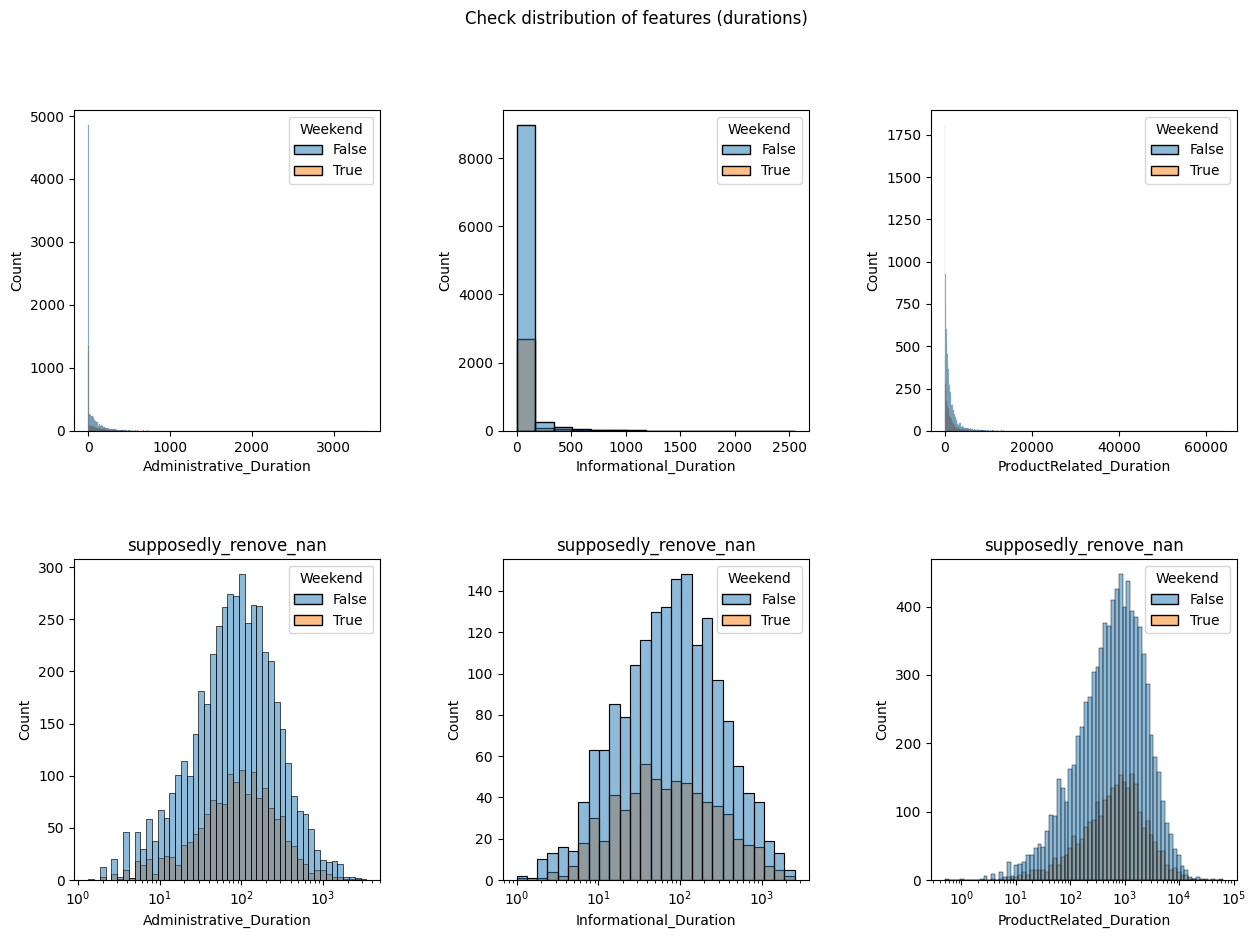

In [8]:
pairs_for_hist_plot = [('Administrative', 'Administrative_Duration'),
                       ('Informational', 'Informational_Duration'), 
                       ('ProductRelated', 'ProductRelated_Duration')]

n, m = 2, 3
fig, axes = plt.subplots(n, m, figsize=(15, 10))
fig.suptitle('Check distribution of features (durations)')

for i, (cat, value) in enumerate(pairs_for_hist_plot):
    
    sns.histplot(ax=axes[0, i % m], data=df, x=value, hue='Weekend')
    
    sns.histplot(ax=axes[1, i % m], data=df[df[value] != 0.0], x=value, hue='Weekend', log_scale=True)
    axes[1, i % m].set_title('supposedly_renove_nan')
    
plt.subplots_adjust(wspace=0.4,
                    hspace=0.4)

Много нулевых значений, очень похоже, что были наны и их заполнили нулями. 
Возможно, есть смысл прологарифмировать значения и попробовать обучить GaussianNB на этих фичах, а потом использовать стекинг.

/var/folders/y3/3vlj_fsd2119kpzsz__bhw7m0000gn/T/ipykernel_79945/424172236.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


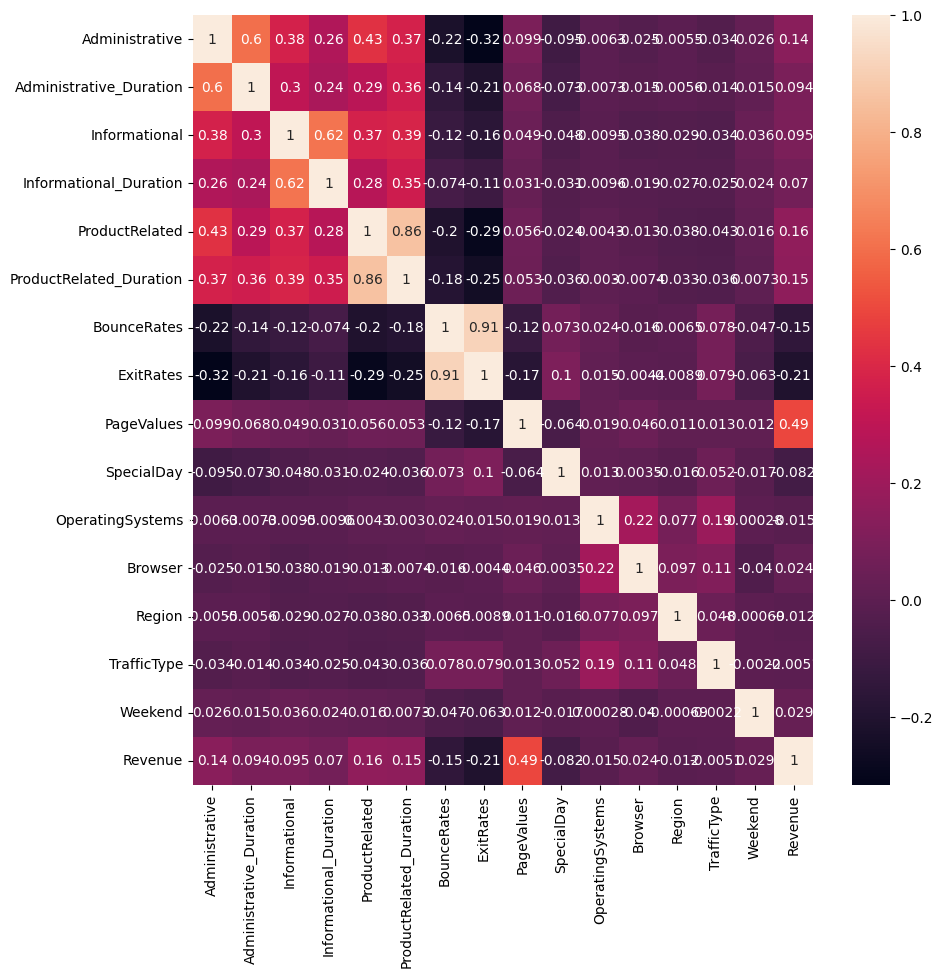

In [9]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True)

pass

- Достаточно сильная корреляция таргета и PageValues, т.е как фичу точно оставляем
- Корреляция между парами (Administrative, Administrative_Duration, ...) и тд, что нехорошо, если будем использовать линейные модели, так как можем столкнуться с проблемой мультиколлениарности со всеми вытекающими 
- Аналогично сильная корреляция между BounceRates и ExitRates

<AxesSubplot: xlabel='ExitRates', ylabel='Count'>

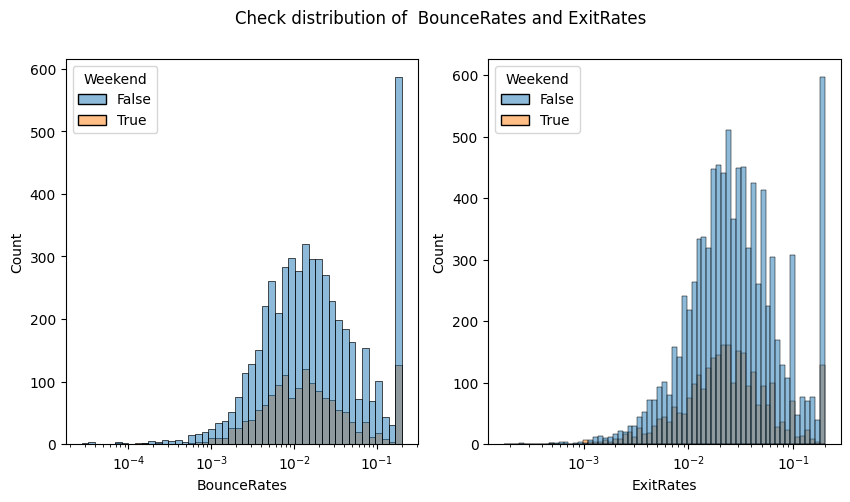

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Check distribution of  BounceRates and ExitRates')

sns.histplot(ax=axes[0], data=df[df['BounceRates'] != 0.0], x='BounceRates', hue='Weekend', log_scale=True)
sns.histplot(ax=axes[1], data=df[df['ExitRates'] != 0.0], x='ExitRates', hue='Weekend', log_scale=True)

Распределения сильно коррелируют, поэтому для линейной модели лучше оставить ExitRate, так как корреляция с таргетом больше + меньше нулей (предположительно заполняемость).

<AxesSubplot: xlabel='PageValues', ylabel='Count'>

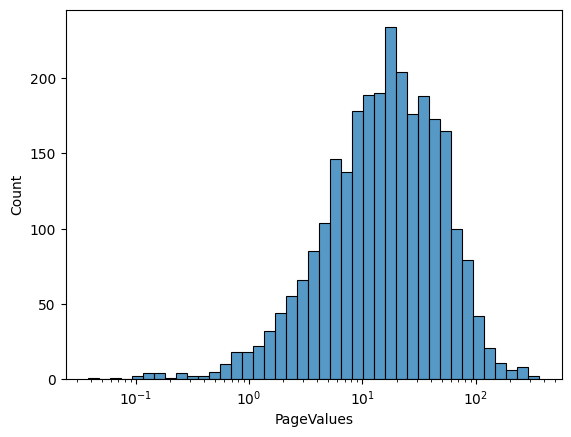

In [11]:
sns.histplot(data=df[df['PageValues'] != 0.0], x='PageValues', log_scale=True)

In [12]:
df['VisitorType'].value_counts()

Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: VisitorType, dtype: int64

In [13]:
df['Revenue'].value_counts()

False    10422
True      1908
Name: Revenue, dtype: int64

Дисбалланс классов -> выбор соответствующих метрик: Roc Auc, f1_score (macro). На всякий еще посморю как себя ведут f1_score (weighted) и (balanced_accuracy_score)

In [14]:
f1_score = metrics.make_scorer(metrics.f1_score, average='macro')

class metrics_test():
    def __init__(self):
        self.f1_macro = partial(metrics.f1_score, average='macro')
        self.f1_weighted = partial(metrics.f1_score, average='weighted')
        self.balanced_acc = metrics.balanced_accuracy_score
        self.roc_auc = metrics.roc_auc_score
        
met_test = metrics_test()

In [15]:
df_res = pd.DataFrame(columns = ['Model', 'F1-score (macro)', 'RocAuc-score',  'F1-score (weighted)', 'Balanced accuracy'])

### Split

In [27]:
X, y = df.iloc[:, :-1], df.iloc[:, -1].astype(int)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Models

### 2.0 Primitive Baseline

In [19]:
_, _, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [20]:
Utils.scores_according_max_occur(y_train, y_test, met_test)

 F1-score (macro)    0.46 
 F1-score (weighted) 0.92 
 Balanced accuracy   0.85


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


### 2.1 LogisticRegression

In [29]:
X_lr = X.drop(columns=['Administrative', 'Informational', 'ProductRelated', 'BounceRates'])

In [30]:
X_lr = pd.get_dummies(X_lr, columns=['Month', 'OperatingSystems', 'Browser', 'Region', 
                                   'TrafficType', 'VisitorType', 'Weekend'])

In [31]:
X_lr = Utils.log_cols(X_lr, cols_to_log=['Informational_Duration', 'ProductRelated_Duration', 'Administrative_Duration',
                                         'PageValues', 'ExitRates'], fill_zeros='ones')

/var/folders/y3/3vlj_fsd2119kpzsz__bhw7m0000gn/T/ipykernel_79945/2699878757.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col] == 0.0] = 1


In [32]:
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y, test_size=0.2, random_state=42, stratify=y)

In [36]:
param_grid = {'penalty': ('l2', 'l1'), 
              'C':[0.1, 1, 10], 
              'solver': ('saga', 'liblinear')}

lr = LogisticRegression()

grid = GridSearchCV(lr, 
                    param_grid,
                    cv=3,
                    scoring=f1_score,
                    return_train_score=True,
                    verbose=0,
                    refit=Utils.refit_strategy,
                    n_jobs=-1)

In [37]:
pipe = make_pipeline(StandardScaler(), grid)
pipe.fit(X_train_lr, y_train_lr)

pass

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: roc_auc_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: roc_auc_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/opt/homebrew/lib/

In [35]:
df_res = Utils.best_result_to_df(df_res, X_test_lr, y_test_lr, 'LogReg', pipe)

 F1-score (macro)    0.77 
 RocAuc-score        0.81 
 F1-score (weighted) 0.9 
 Balanced accuracy   0.81 



/var/folders/y3/3vlj_fsd2119kpzsz__bhw7m0000gn/T/ipykernel_79945/2699878757.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Model': name_est,


### 2.2 SVM

In [39]:
svc = SVC()

param_grid = {'C': [0.1, 1.0, 5.0, 15.0], 'kernel': ['linear', 'rbf', 'poly']}

grid = GridSearchCV(svc, 
                    param_grid,
                    cv=3,
                    scoring=f1_score,
                    return_train_score=True,
                    verbose=0,
                    n_jobs=-1)

In [40]:
pipe = make_pipeline(StandardScaler(), grid)
pipe.fit(X_train_lr, y_train_lr)

pass

In [41]:
df_res = Utils.best_result_to_df(df_res, X_test_lr, y_test_lr, 'SVM', pipe)

 F1-score (macro)    0.78 
 RocAuc-score        0.78 
 F1-score (weighted) 0.89 
 Balanced accuracy   0.78 



/var/folders/y3/3vlj_fsd2119kpzsz__bhw7m0000gn/T/ipykernel_79945/2699878757.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Model': name_est,


### 2.3 Random Forest

In [42]:
rf = RandomForestClassifier()

param_grid = {'n_estimators': [100, 1000, 2000, 5000], 
              'class_weight': ['balanced'], 'min_samples_split': [2, 10], 
              'min_samples_leaf': [1, 5, 15], 
              'max_depth':[None, 5, 15, 30, 100], 
              'n_jobs': [-1]}



grid = GridSearchCV(rf, 
                    param_grid,
                    cv=3,
                    scoring=metrics.roc_auc_score,
                    return_train_score=True,
                    verbose=0,
                    refit=Utils.refit_strategy,
                    n_jobs=-1)

In [43]:
pipe = make_pipeline(StandardScaler(), grid)
pipe.fit(X_train_lr, y_train_lr)

pass

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: roc_auc_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: roc_auc_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/opt/homebrew/lib/

In [44]:
df_res = Utils.best_result_to_df(df_res, X_test_lr, y_test_lr, 'Random Forest', pipe)

 F1-score (macro)    0.76 
 RocAuc-score        0.83 
 F1-score (weighted) 0.9 
 Balanced accuracy   0.83 



/var/folders/y3/3vlj_fsd2119kpzsz__bhw7m0000gn/T/ipykernel_79945/2699878757.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Model': name_est,


### 2.4 Boostimg

In [46]:
cat_features = ['Administrative', 'Informational', 'ProductRelated',
                'Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']

In [47]:
params = {'loss_function': 'Logloss',
          'iterations': 50, 
          'custom_loss': 'AUC', 
          'random_seed': 42,
          'learning_rate': 0.2}

cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=cat_features),
    fold_count=3,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=True,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.2316155322
bestIteration = 31

Training on fold [1/3]

bestTest = 0.226259096
bestIteration = 48

Training on fold [2/3]

bestTest = 0.2189350459
bestIteration = 40



In [48]:
cv_data.head()

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
0,0,0.490743,0.006130,0.489756,0.008630,0.883991,0.006380
1,1,0.381788,0.002758,0.380037,0.005484,0.900577,0.008575
2,2,0.327076,0.002959,0.325020,0.001988,0.906481,0.005808
3,3,0.288458,0.006440,0.286270,0.010695,0.918858,0.005550
4,4,0.266686,0.001994,0.263582,0.005086,0.923701,0.005886


In [49]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Best validation Logloss score, stratified: 0.2259±0.0061 on step 48


In [50]:
X_test = Utils.log_cols(X_test, cols_to_log=['Informational_Duration', 'ProductRelated_Duration', 'Administrative_Duration',
                                         'PageValues', 'ExitRates'], fill_zeros='ones')

X_train = Utils.log_cols(X_train, cols_to_log=['Informational_Duration', 'ProductRelated_Duration', 'Administrative_Duration',
                                         'PageValues', 'ExitRates'], fill_zeros='ones')

/var/folders/y3/3vlj_fsd2119kpzsz__bhw7m0000gn/T/ipykernel_79945/2699878757.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col] == 0.0] = 1
/var/folders/y3/3vlj_fsd2119kpzsz__bhw7m0000gn/T/ipykernel_79945/2699878757.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col] == 0.0] = 1
/var/folders/y3/3vlj_fsd2119kpzsz__bhw7m0000gn/T/ipykernel_79945/2699878757.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

In [51]:
model = CatBoostClassifier(
    iterations=48,
    random_seed=42,
    learning_rate=0.2,
    custom_loss=['AUC']
)


model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [52]:
df_res = Utils.lgb_res(model, df_res, X_test, y_test, 'CatBoost')

 F1-score (macro)    0.8 
 RocAuc-score        0.83 
 F1-score (weighted) 0.91 
 Balanced accuracy   0.83 



/var/folders/y3/3vlj_fsd2119kpzsz__bhw7m0000gn/T/ipykernel_79945/2699878757.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Model': name_est,


In [53]:
df_res

,Model,F1-score (macro),RocAuc-score,F1-score (weighted),Balanced accuracy
0,LogReg,0.77,0.81,0.90,0.81
1,SVM,0.78,0.78,0.89,0.78
2,Random Forest,0.76,0.83,0.90,0.83
3,CatBoost,0.80,0.83,0.91,0.83
